# 🔥 PyTorch Fundamentals Lab - Day 2 (ฉบับภาษาไทย)
**Datasets, DataLoaders, CNNs, RNNs และ Best Practices**

## 📚 สิ่งที่คุณจะได้เรียนรู้:
- **Datasets & DataLoaders** - การจัดการข้อมูลอย่างมีประสิทธิภาพ
- **Image Folder DataLoader** - การโหลดรูปภาพจากโฟลเดอร์
- **Transforms & Augmentation** - การเตรียมและเพิ่มข้อมูล
- **CNN** - Convolutional Neural Networks สำหรับรูปภาพ
- **RNN/LSTM** - Recurrent Networks สำหรับ Sequential Data
- **Training Best Practices** - เทคนิคการ train ที่ดี
- **GPU Optimization** - การใช้ GPU อย่างมีประสิทธิภาพ

## 📝 Prerequisites:
ควรผ่าน Day 1 มาก่อน (Tensors, Autograd, Basic Neural Networks)

---
# 📦 Module 1: Setup
---

In [61]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, WeightedRandomSampler
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from collections import Counter
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import os

# ตั้งค่า
print(f"📦 PyTorch version: {torch.__version__}")
print(f"📦 Torchvision version: {torchvision.__version__}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🎮 Using device: {device}")

if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")

📦 PyTorch version: 2.9.1+cu128
📦 Torchvision version: 0.24.1+cu128
🎮 Using device: cuda
   GPU: NVIDIA GeForce RTX 5090


In [62]:
def set_seed(seed=42):
    """ตั้งค่า seed สำหรับ reproducibility"""
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(42)
print("🌱 Seed set to 42")

🌱 Seed set to 42


---
# 📊 Module 2: Datasets และ DataLoaders
---

## ทำไมต้องใช้ Dataset และ DataLoader?

**ปัญหา:** ในการ train จริง ข้อมูลมักจะ:
- ใหญ่มาก → โหลดเข้า RAM ทีเดียวไม่ได้
- ต้อง shuffle → ไม่งั้น model จะจำลำดับแทนที่จะเรียนรู้ pattern
- ต้องแบ่งเป็น batch → GPU ทำงานได้ดีกว่าเมื่อประมวลผลหลายๆ ตัวพร้อมกัน

**วิธีแก้:**
- **Dataset** = "สูตรอาหาร" บอกว่าข้อมูลอยู่ที่ไหน เข้าถึงยังไง
- **DataLoader** = "พ่อครัว" จัดการทุกอย่างให้ (shuffle, แบ่ง batch, โหลดล่วงหน้า)

## 2.1 สร้าง Custom Dataset

**หลักการง่ายๆ:** Dataset ต้องมี 3 methods:
1. `__init__()` → เตรียมข้อมูล (เรียกครั้งเดียวตอนสร้าง)
2. `__len__()` → บอกว่ามีข้อมูลกี่ตัว
3. `__getitem__(idx)` → ดึงข้อมูลตัวที่ idx ออกมา

**เปรียบเทียบ:** เหมือนหนังสือ
- `__init__` = พิมพ์หนังสือ
- `__len__` = จำนวนหน้า
- `__getitem__` = เปิดไปหน้าที่ต้องการ

In [63]:
class SimpleDataset(Dataset):
    """
    Custom Dataset สำหรับ XOR problem
    
    XOR คือ:
    - (0,0) → 0  (เหมือนกัน = 0)
    - (0,1) → 1  (ต่างกัน = 1)
    - (1,0) → 1  (ต่างกัน = 1)
    - (1,1) → 0  (เหมือนกัน = 0)
    
    ปัญหานี้ยากเพราะไม่สามารถแบ่งด้วยเส้นตรงเส้นเดียวได้!
    """
    
    def __init__(self, n_samples=1000, noise=0.1):
        """
        Args:
            n_samples: จำนวนข้อมูลที่ต้องการ
            noise: ระดับ noise (ความสุ่ม) ที่เพิ่มเข้าไป
        """
        # สร้างจุดสุ่มในช่วง [0, 1]
        self.X = torch.rand(n_samples, 2)
        
        # XOR logic: ถ้าอยู่คนละฝั่งของ 0.5 = class 1
        # ^ คือ XOR operator ใน Python
        xor_values = (self.X[:, 0] > 0.5) ^ (self.X[:, 1] > 0.5)
        self.y = xor_values.long()
        
        # เพิ่ม noise เพื่อให้ realistic ขึ้น
        self.X = self.X + noise * torch.randn_like(self.X)
    
    def __len__(self):
        """บอกจำนวนข้อมูลทั้งหมด"""
        return len(self.y)
    
    def __getitem__(self, idx):
        """ดึงข้อมูล 1 ตัวที่ index idx"""
        return self.X[idx], self.y[idx]

# สร้าง dataset
dataset = SimpleDataset(n_samples=1000)
print(f"Dataset size: {len(dataset)}")

# ดูตัวอย่างข้อมูล
x, y = dataset[0]
print(f"Sample 0: x={x}, y={y}")

Dataset size: 1000
Sample 0: x=tensor([0.7830, 0.8894]), y=0


## 2.2 Visualize Dataset

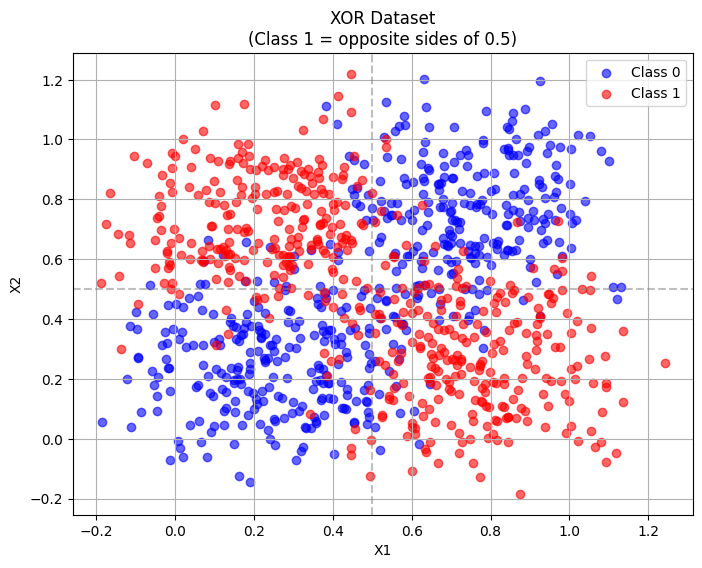

In [64]:
# Visualize XOR dataset
X_all = dataset.X.numpy()
y_all = dataset.y.numpy()

plt.figure(figsize=(8, 6))
plt.scatter(X_all[y_all == 0, 0], X_all[y_all == 0, 1], 
            c='blue', label='Class 0', alpha=0.6)
plt.scatter(X_all[y_all == 1, 0], X_all[y_all == 1, 1], 
            c='red', label='Class 1', alpha=0.6)
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('XOR Dataset\n(Class 1 = opposite sides of 0.5)')
plt.legend()
plt.grid(True)
plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
plt.axvline(x=0.5, color='gray', linestyle='--', alpha=0.5)

plt.show()

## 2.3 DataLoader - การโหลดข้อมูลเป็น Batches

**DataLoader ทำอะไรบ้าง:**
- **batch_size** → รวมข้อมูลกี่ตัวเป็น 1 batch (เช่น 32 รูปต่อครั้ง)
- **shuffle** → สลับลำดับข้อมูล (สำคัญตอน train!)
- **num_workers** → ใช้กี่ CPU cores โหลดข้อมูล (มากกว่า 0 = เร็วขึ้น)
- **drop_last** → ทิ้ง batch สุดท้ายถ้าไม่ครบ (เช่น เหลือ 20 ตัว แต่ batch_size=32)

**ทำไม batch_size สำคัญ:**
- เล็กเกินไป (1-4) → train นาน, noisy gradients
- ใหญ่เกินไป (512+) → RAM/GPU ไม่พอ, generalize ได้แย่ลง
- พอดี (16-128) → balance ระหว่างความเร็วและคุณภาพ

In [65]:
# สร้าง DataLoader
dataloader = DataLoader(
    dataset,
    batch_size=32,      # 32 samples ต่อ batch
    shuffle=True,       # สลับลำดับทุก epoch
    num_workers=0,      # ใช้ main process (ใส่ >0 สำหรับ parallel loading)
    drop_last=False     # เก็บ batch สุดท้ายแม้ไม่ครบ
)

print(f"Number of batches: {len(dataloader)}")
print(f"Batch size: {dataloader.batch_size}")

Number of batches: 32
Batch size: 32


## 2.4 การใช้งาน DataLoader

In [66]:
# Iterate ผ่าน DataLoader
print("First 3 batches:")
for i, (X_batch, y_batch) in enumerate(dataloader):
    print(f"  Batch {i}: X shape = {X_batch.shape}, y shape = {y_batch.shape}")
    if i >= 2:
        break

First 3 batches:
  Batch 0: X shape = torch.Size([32, 2]), y shape = torch.Size([32])
  Batch 1: X shape = torch.Size([32, 2]), y shape = torch.Size([32])
  Batch 2: X shape = torch.Size([32, 2]), y shape = torch.Size([32])


## 2.5 แบ่ง Train/Validation/Test Sets

**ทำไมต้องแบ่ง 3 ส่วน?**

| ส่วน | สัดส่วน | ใช้ทำอะไร | แตะกี่ครั้ง |
|------|---------|-----------|-------------|
| **Train** | 70-80% | สอน model | ทุก epoch |
| **Validation** | 10-15% | tune hyperparameters, ดู overfitting | ทุก epoch |
| **Test** | 10-15% | ประเมินผลสุดท้าย | **ครั้งเดียว!** |

**หลักสำคัญ:** ห้ามแตะ Test set จนกว่า model จะเสร็จสมบูรณ์!

In [67]:
# สร้าง dataset
full_dataset = SimpleDataset(n_samples=1000)

# แบ่งข้อมูล
train_size = int(0.7 * len(full_dataset))  # 70%
val_size = int(0.15 * len(full_dataset))   # 15%
test_size = len(full_dataset) - train_size - val_size  # 15%

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, 
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)  # reproducible split
)

print(f"Train: {len(train_dataset)} samples")
print(f"Val: {len(val_dataset)} samples")
print(f"Test: {len(test_dataset)} samples")

Train: 700 samples
Val: 150 samples
Test: 150 samples


In [68]:
# สร้าง DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)  # ไม่ต้อง shuffle
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Train batches: 22
Val batches: 5
Test batches: 5


## 2.6 Built-in Datasets จาก Torchvision

**ข้อดี:** ไม่ต้องเขียน Dataset เอง, download อัตโนมัติ

**Datasets ยอดนิยม:**
- **MNIST** → ตัวเลขเขียนมือ 0-9 (28×28 grayscale) - ง่ายสุด
- **CIFAR-10** → รูปสี 10 ประเภท (32×32) - กลางๆ
- **CIFAR-100** → รูปสี 100 ประเภท - ยากขึ้น
- **ImageNet** → รูปจริง 1000 ประเภท - ยากมาก

In [69]:
# โหลด MNIST dataset
mnist_train = torchvision.datasets.MNIST(
    root='./data',           # โฟลเดอร์เก็บข้อมูล
    train=True,              # training set
    download=True,           # download ถ้ายังไม่มี
    transform=transforms.ToTensor()  # แปลงเป็น tensor
)

mnist_test = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

print(f"MNIST Training: {len(mnist_train)} images")
print(f"MNIST Test: {len(mnist_test)} images")

MNIST Training: 60000 images
MNIST Test: 10000 images


## 2.7 สำรวจ MNIST Dataset

In [70]:
# ดูตัวอย่างรูปภาพ
image, label = mnist_train[0]
print(f"Image shape: {image.shape}")  # (1, 28, 28) = (Channels, Height, Width)
print(f"Label: {label}")
print(f"Pixel range: [{image.min():.2f}, {image.max():.2f}]")

Image shape: torch.Size([1, 28, 28])
Label: 5
Pixel range: [0.00, 1.00]


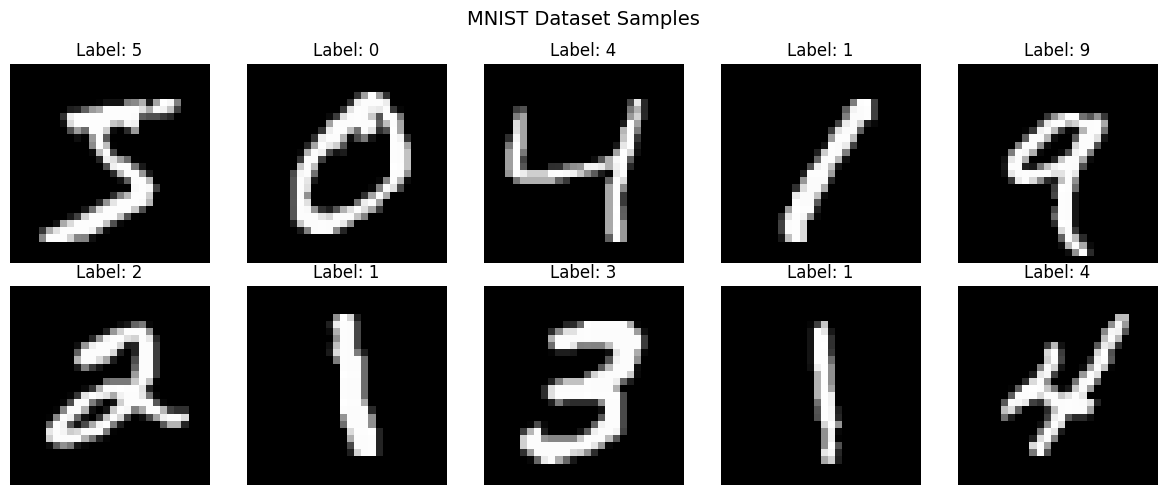

In [71]:
# แสดงตัวอย่างรูปภาพ
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    image, label = mnist_train[i]
    ax.imshow(image.squeeze(), cmap='gray')
    ax.set_title(f'Label: {label}')
    ax.axis('off')
plt.suptitle('MNIST Dataset Samples', fontsize=14)
plt.tight_layout()

plt.show()

---
# 📷 Module 2.5: DataLoader จาก Image Folder (Real-World Images)
---

## เมื่อข้อมูลเป็นรูปภาพในโฟลเดอร์

**ในโลกจริง ข้อมูลรูปภาพมักจะ:**
- เก็บเป็นไฟล์ในโฟลเดอร์ (jpg, png)
- จัดเรียงตาม class (แต่ละ class = 1 โฟลเดอร์)
- ขนาดไม่เท่ากัน → ต้อง resize

**โครงสร้างที่พบบ่อย:**
```
dataset/
├── train/
│   ├── class_1/
│   │   ├── img001.jpg
│   │   └── img002.jpg
│   └── class_2/
│       └── img003.jpg
└── val/
    ├── class_1/
    └── class_2/
```

## 📁 ตัวอย่าง: Animal Faces Dataset (AFHQ)
```
afhq/
├── train/
│   ├── cat/      (~5000 images)
│   ├── dog/      (~5000 images)
│   └── wild/     (~5000 images)
└── val/
    ├── cat/      (~500 images)
    ├── dog/      (~500 images)
    └── wild/     (~500 images)
```

## 2.8 Download Dataset จาก Kaggle

In [72]:
import kagglehub

# ✅ ตั้งค่า Kaggle API credentials (จาก kaggle.json)
os.environ["KAGGLE_USERNAME"] = "your_username"  # ← แก้เป็นของคุณ
os.environ["KAGGLE_KEY"] = "your_api_key"        # ← แก้เป็นของคุณ

# ✅ กำหนดที่เก็บ cache ของ kagglehub (optional)
os.environ["KAGGLEHUB_CACHE"] = os.path.abspath("./kaggle_cache")

# Download dataset
dataset_dir = kagglehub.dataset_download("andrewmvd/animal-faces")

print(f"✅ Dataset downloaded to: {dataset_dir}")

100%|██████████| 696M/696M [00:45<00:00, 16.1MB/s] 

Extracting files...


✅ Dataset downloaded to: /home/student/workspace/basic_pytorch/kaggle_cache/datasets/andrewmvd/animal-faces/versions/1


## 2.9 ตรวจสอบโครงสร้าง Dataset และหา Path ที่ถูกต้อง

In [73]:
def find_dataset_paths(base_dir):
    """
    หา train และ val directories จาก base_dir
    
    Args:
        base_dir: path ที่ได้จาก kagglehub.dataset_download()
    
    Returns:
        tuple: (train_dir, val_dir) หรือ (None, None) ถ้าไม่เจอ
    """
    train_dir = None
    val_dir = None
    
    # แสดงโครงสร้าง folder
    print(f"📁 Searching in: {base_dir}")
    print(f"📁 Contents:")
    
    for item in os.listdir(base_dir):
        item_path = os.path.join(base_dir, item)
        if os.path.isdir(item_path):
            print(f"   📂 {item}/")
            # ดู sub-folders
            for sub_item in os.listdir(item_path):
                sub_path = os.path.join(item_path, sub_item)
                if os.path.isdir(sub_path):
                    print(f"      └── {sub_item}/")
    
    # หา train folder
    print(f"\n🔍 Searching for 'train' folder...")
    
    for root, dirs, files in os.walk(base_dir):
        if 'train' in dirs:
            train_dir = os.path.join(root, 'train')
            val_dir = os.path.join(root, 'val')
            print(f"   ✅ Found train at: {train_dir}")
            print(f"   ✅ Found val at: {val_dir}")
            
            # แสดง classes
            if os.path.exists(train_dir):
                classes = [d for d in os.listdir(train_dir) 
                          if os.path.isdir(os.path.join(train_dir, d))]
                print(f"   📋 Classes: {classes}")
            break
    
    if train_dir is None:
        print("   ❌ Could not find 'train' folder!")
    
    return train_dir, val_dir


# หา paths
TRAIN_DIR, VAL_DIR = find_dataset_paths(dataset_dir)

# ตรวจสอบว่า paths มีอยู่จริง
if TRAIN_DIR and os.path.exists(TRAIN_DIR):
    print(f"\n✅ TRAIN_DIR is valid: {TRAIN_DIR}")
    print(f"✅ VAL_DIR is valid: {VAL_DIR}")
else:
    print("\n❌ Paths not found! Please check dataset structure manually.")

📁 Searching in: /home/student/workspace/basic_pytorch/kaggle_cache/datasets/andrewmvd/animal-faces/versions/1
📁 Contents:
   📂 afhq/
      └── train/
      └── val/

🔍 Searching for 'train' folder...
   ✅ Found train at: /home/student/workspace/basic_pytorch/kaggle_cache/datasets/andrewmvd/animal-faces/versions/1/afhq/train
   ✅ Found val at: /home/student/workspace/basic_pytorch/kaggle_cache/datasets/andrewmvd/animal-faces/versions/1/afhq/val
   📋 Classes: ['cat', 'dog', 'wild']

✅ TRAIN_DIR is valid: /home/student/workspace/basic_pytorch/kaggle_cache/datasets/andrewmvd/animal-faces/versions/1/afhq/train
✅ VAL_DIR is valid: /home/student/workspace/basic_pytorch/kaggle_cache/datasets/andrewmvd/animal-faces/versions/1/afhq/val


## 2.10 สร้าง Transforms

In [74]:
# === Transform สำหรับ Training ===
# รวม augmentation + preprocessing
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),          # ปรับขนาดให้เท่ากัน
    transforms.RandomHorizontalFlip(p=0.5), # พลิกซ้าย-ขวา 50%
    transforms.RandomRotation(15),          # หมุน ±15 องศา
    transforms.ColorJitter(
        brightness=0.2,
        contrast=0.2,
        saturation=0.2,
        hue=0.1
    ),
    transforms.ToTensor(),                  # แปลงเป็น tensor [0, 1]
    transforms.Normalize(                   # Normalize ด้วย ImageNet stats
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# === Transform สำหรับ Validation/Test ===
# ไม่มี augmentation เพราะต้องการผลที่คงที่
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

print("✅ Transforms ready!")
print("   Train: Resize → Flip → Rotate → ColorJitter → Normalize")
print("   Val:   Resize → Normalize (ไม่มี augmentation)")

✅ Transforms ready!
   Train: Resize → Flip → Rotate → ColorJitter → Normalize
   Val:   Resize → Normalize (ไม่มี augmentation)


## 2.11 สร้าง Dataset ด้วย ImageFolder

In [75]:
# === สร้าง Dataset ด้วย ImageFolder ===
# ใช้ TRAIN_DIR และ VAL_DIR ที่หาได้จากขั้นตอนก่อนหน้า

train_dataset_img = ImageFolder(root=TRAIN_DIR, transform=train_transform)
val_dataset_img = ImageFolder(root=VAL_DIR, transform=val_transform)

print(f"✅ Training samples: {len(train_dataset_img)}")
print(f"✅ Validation samples: {len(val_dataset_img)}")
print(f"✅ Classes: {train_dataset_img.classes}")
print(f"✅ Class to index: {train_dataset_img.class_to_idx}")

✅ Training samples: 14630
✅ Validation samples: 1500
✅ Classes: ['cat', 'dog', 'wild']
✅ Class to index: {'cat': 0, 'dog': 1, 'wild': 2}


## 2.12 สร้าง DataLoader

In [76]:
# === สร้าง DataLoader ===
train_loader_img = DataLoader(
    train_dataset_img,
    batch_size=32,
    shuffle=True,           # สำคัญ! สลับลำดับตอน train
    num_workers=4,          # ใช้ 4 CPU cores โหลดข้อมูล
    pin_memory=True         # เร็วขึ้นถ้าใช้ GPU
)

val_loader_img = DataLoader(
    val_dataset_img,
    batch_size=32,
    shuffle=False,          # ไม่ต้อง shuffle ตอน validate
    num_workers=4,
    pin_memory=True
)

print(f"📦 Train batches: {len(train_loader_img)}")
print(f"📦 Val batches: {len(val_loader_img)}")

📦 Train batches: 458
📦 Val batches: 47


## 2.13 ทดสอบดึงข้อมูล 1 batch

In [77]:
# === ทดสอบดึงข้อมูล 1 batch ===
images, labels = next(iter(train_loader_img))

print(f"🖼️ Batch images shape: {images.shape}")  # (32, 3, 224, 224)
print(f"🏷️ Batch labels shape: {labels.shape}")  # (32,)
print(f"🏷️ Labels sample: {labels[:5].tolist()}")
print(f"🏷️ Class names: {[train_dataset_img.classes[l] for l in labels[:5].tolist()]}")

🖼️ Batch images shape: torch.Size([32, 3, 224, 224])
🏷️ Batch labels shape: torch.Size([32])
🏷️ Labels sample: [1, 0, 0, 2, 1]
🏷️ Class names: ['dog', 'cat', 'cat', 'wild', 'dog']


## 2.14 แสดงตัวอย่างรูปจาก Dataset

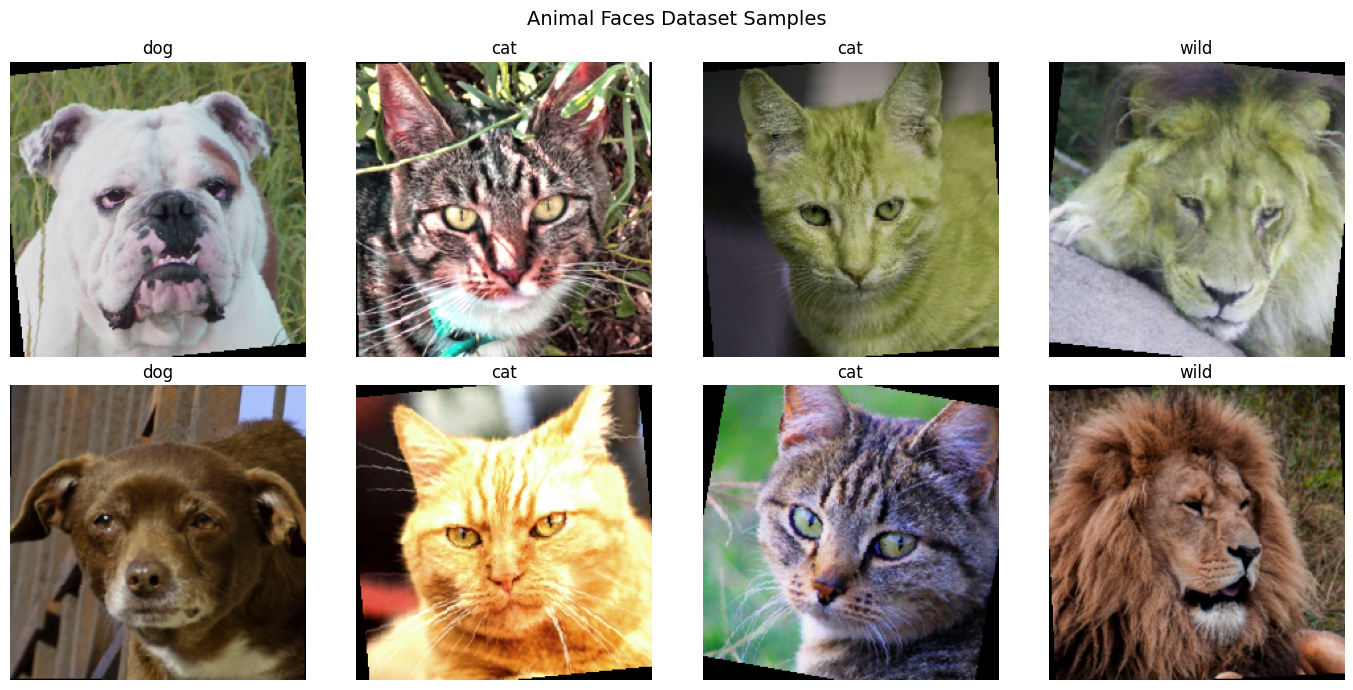

In [78]:
def show_batch(images, labels, class_names, n_images=8):
    """
    แสดงรูปจาก batch
    
    Args:
        images: tensor shape (B, C, H, W)
        labels: tensor shape (B,)
        class_names: list ของชื่อ class
        n_images: จำนวนรูปที่จะแสดง
    """
    # Denormalize สำหรับแสดงผล (ImageNet stats)
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    
    fig, axes = plt.subplots(2, 4, figsize=(14, 7))
    
    for i, ax in enumerate(axes.flat):
        if i >= n_images or i >= len(images):
            ax.axis('off')
            continue
        
        # Denormalize
        img = images[i] * std + mean
        img = img.permute(1, 2, 0).numpy()  # (C, H, W) → (H, W, C)
        img = img.clip(0, 1)  # จำกัดค่าให้อยู่ใน [0, 1]
        
        ax.imshow(img)
        ax.set_title(f'{class_names[labels[i]]}', fontsize=12)
        ax.axis('off')
    
    plt.suptitle('Animal Faces Dataset Samples', fontsize=14)
    plt.tight_layout()
    plt.show()

# แสดงรูป
show_batch(images, labels, train_dataset_img.classes)

## 2.15 Custom Dataset สำหรับ Images (Alternative Method)

**ใช้เมื่อ:**
- โครงสร้างโฟลเดอร์ไม่มาตรฐาน
- ต้องการ preprocess พิเศษ
- มี metadata เพิ่มเติม (เช่น bounding box, segmentation mask)
- ต้องการ filter ไฟล์เสีย

In [79]:
class CustomImageDataset(Dataset):
    """
    Custom Dataset สำหรับรูปภาพ
    
    ข้อดี:
    - ควบคุมการโหลดได้เต็มที่
    - เพิ่ม logic พิเศษได้ (เช่น filter ไฟล์เสีย)
    - รองรับ metadata เพิ่มเติม
    """
    
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir: path ไปยังโฟลเดอร์ที่มี class folders
            transform: transforms ที่จะใช้กับรูป
        """
        self.root_dir = root_dir
        self.transform = transform
        
        # หา class folders
        self.classes = sorted([d for d in os.listdir(root_dir) 
                               if os.path.isdir(os.path.join(root_dir, d))])
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        
        # รวบรวมรูปทั้งหมด
        self.samples = []
        self.valid_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.webp', '.gif'}
        
        for class_name in self.classes:
            class_dir = os.path.join(root_dir, class_name)
            class_idx = self.class_to_idx[class_name]
            
            for filename in os.listdir(class_dir):
                # ตรวจสอบ extension
                ext = os.path.splitext(filename)[1].lower()
                if ext in self.valid_extensions:
                    filepath = os.path.join(class_dir, filename)
                    self.samples.append((filepath, class_idx))
        
        print(f"Found {len(self.samples)} images in {len(self.classes)} classes")
    
    def __len__(self):
        """จำนวนรูปทั้งหมด"""
        return len(self.samples)
    
    def __getitem__(self, idx):
        """ดึงรูปที่ index idx"""
        img_path, label = self.samples[idx]
        
        # โหลดรูป
        image = Image.open(img_path).convert('RGB')  # แปลงเป็น RGB เสมอ
        
        # Apply transform
        if self.transform:
            image = self.transform(image)
        
        return image, label
    
    def get_class_name(self, idx):
        """แปลง index กลับเป็นชื่อ class"""
        return self.classes[idx]


# ทดสอบ Custom Dataset
print("\n📝 Testing CustomImageDataset...")
custom_train = CustomImageDataset(root_dir=TRAIN_DIR, transform=train_transform)
print(f"   Classes: {custom_train.classes}")
print(f"   Total samples: {len(custom_train)}")

# ดึงตัวอย่าง 1 รูป
img, label = custom_train[0]
print(f"   Image shape: {img.shape}")
print(f"   Label: {label} ({custom_train.get_class_name(label)})")


📝 Testing CustomImageDataset...
Found 14630 images in 3 classes
   Classes: ['cat', 'dog', 'wild']
   Total samples: 14630
   Image shape: torch.Size([3, 224, 224])
   Label: 0 (cat)


## 2.16 การจัดการรูปที่ขนาดต่างกัน

**ปัญหา:** รูปจาก real-world มักมีขนาดไม่เท่ากัน

**วิธีแก้:**

| วิธี | คำอธิบาย | ข้อดี | ข้อเสีย |
|------|----------|-------|---------|
| **Resize** | ปรับขนาดตรงๆ | ง่าย | อาจเสีย aspect ratio |
| **CenterCrop** | crop ตรงกลาง | รักษา aspect ratio | เสียข้อมูลขอบ |
| **RandomResizedCrop** | crop + resize แบบสุ่ม | data augmentation | สุ่มตำแหน่ง |

In [80]:
# === ตัวอย่าง transforms ต่างๆ สำหรับจัดการขนาด ===

# วิธี 1: Resize ตรงๆ (อาจเสีย aspect ratio)
transform_resize = transforms.Compose([
    transforms.Resize((224, 224)),  # บังคับขนาด 224x224
    transforms.ToTensor()
])

# วิธี 2: Resize ให้ด้านสั้นเท่ากับ target แล้ว CenterCrop
transform_center = transforms.Compose([
    transforms.Resize(256),          # ด้านสั้น = 256
    transforms.CenterCrop(224),      # crop ตรงกลาง 224x224
    transforms.ToTensor()
])

# วิธี 3: RandomResizedCrop (ดีสำหรับ training - data augmentation)
transform_random = transforms.Compose([
    transforms.RandomResizedCrop(
        224,
        scale=(0.8, 1.0),    # crop 80-100% ของรูป
        ratio=(0.9, 1.1)     # aspect ratio 0.9-1.1
    ),
    transforms.ToTensor()
])

print("🔄 Resize Strategies:")
print("  1. Resize(224, 224)           → บังคับขนาด (อาจเสีย aspect ratio)")
print("  2. Resize(256) + CenterCrop   → รักษา aspect ratio")
print("  3. RandomResizedCrop(224)     → augmentation + resize")

🔄 Resize Strategies:
  1. Resize(224, 224)           → บังคับขนาด (อาจเสีย aspect ratio)
  2. Resize(256) + CenterCrop   → รักษา aspect ratio
  3. RandomResizedCrop(224)     → augmentation + resize


## 2.17 Weighted Sampling สำหรับ Imbalanced Data

**ปัญหา:** บางครั้ง class มีจำนวนไม่เท่ากัน
- เช่น cat=1000, dog=5000 รูป
- Model จะ bias ไปทาง class ที่มีมาก

**วิธีแก้:** ใช้ WeightedRandomSampler
- class ที่มีน้อย → weight สูง → ถูก sample บ่อยขึ้น

In [81]:
def create_weighted_sampler(dataset):
    """
    สร้าง WeightedRandomSampler สำหรับ imbalanced dataset
    
    หลักการ: class ที่มีน้อย → weight สูง → ถูก sample บ่อยขึ้น
    
    Args:
        dataset: Dataset ที่มี attribute targets หรือ samples
    
    Returns:
        WeightedRandomSampler
    """
    # นับจำนวนแต่ละ class
    if hasattr(dataset, 'targets'):
        # ImageFolder มี attribute targets
        targets = dataset.targets
    elif hasattr(dataset, 'samples'):
        # Custom dataset ที่มี samples = [(path, label), ...]
        targets = [label for _, label in dataset.samples]
    else:
        raise ValueError("Dataset must have 'targets' or 'samples' attribute")
    
    class_counts = Counter(targets)
    print(f"📊 Class distribution: {dict(class_counts)}")
    
    # คำนวณ weight (inverse of frequency)
    # class ที่มีน้อย → weight สูง
    total = len(targets)
    class_weights = {cls: total / count for cls, count in class_counts.items()}
    print(f"📊 Class weights: {class_weights}")
    
    # สร้าง weight สำหรับแต่ละ sample
    sample_weights = [class_weights[label] for label in targets]
    
    # สร้าง sampler
    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(targets),
        replacement=True  # ต้องเป็น True สำหรับ oversampling
    )
    
    return sampler


# ตัวอย่างการใช้งาน
print("\n📝 Creating WeightedRandomSampler...")
sampler = create_weighted_sampler(train_dataset_img)

# ใช้ sampler แทน shuffle
train_loader_balanced = DataLoader(
    train_dataset_img,
    batch_size=32,
    sampler=sampler,    # ← ใช้ sampler แทน shuffle=True
    num_workers=4,
    pin_memory=True
)

print(f"✅ Balanced DataLoader created with {len(train_loader_balanced)} batches")


📝 Creating WeightedRandomSampler...
📊 Class distribution: {0: 5153, 1: 4739, 2: 4738}
📊 Class weights: {0: 2.839122841063458, 1: 3.087149187592319, 2: 3.0878007598142676}
✅ Balanced DataLoader created with 458 batches


## 2.18 เปรียบเทียบ ImageFolder vs Custom Dataset

| Feature | ImageFolder | Custom Dataset |
|---------|-------------|----------------|
| **ความง่าย** | ✅ ง่ายมาก | ❌ ต้องเขียนเอง |
| **Flexibility** | ❌ จำกัด | ✅ ทำอะไรก็ได้ |
| **โครงสร้างมาตรฐาน** | ✅ ต้องตามมาตรฐาน | ✅ อะไรก็ได้ |
| **Metadata** | ❌ แค่ path + label | ✅ เพิ่มได้ตามใจ |
| **Filter/Validate** | ❌ ไม่มี | ✅ ทำได้ |

**สรุป:**
- ใช้ **ImageFolder** เมื่อข้อมูลจัดเรียงตามมาตรฐาน (เร็วและง่าย)
- ใช้ **Custom Dataset** เมื่อต้องการ control มากขึ้น

## 2.19 Best Practices สำหรับ Image Data

**🎯 สิ่งที่ควรทำ:**

1. **Normalize ด้วย ImageNet stats** (ถ้าใช้ pretrained model)
   ```python
   mean=[0.485, 0.456, 0.406]
   std=[0.229, 0.224, 0.225]
   ```

2. **ใช้ augmentation เฉพาะตอน train**
   - Train: RandomHorizontalFlip, RandomRotation, ColorJitter
   - Val/Test: แค่ Resize + Normalize

3. **เลือก image size ให้เหมาะสม**
   - 224×224: มาตรฐาน (ResNet, VGG)
   - 299×299: Inception
   - 384×384, 512×512: ViT, high-resolution tasks

4. **ตรวจสอบ channel order**
   - PIL Image: (H, W, C) RGB
   - OpenCV: (H, W, C) BGR ← ระวัง! ต้องแปลงก่อน
   - PyTorch Tensor: (C, H, W)

5. **num_workers ที่เหมาะสม**
   - Windows: 0 (มี bug กับ multiprocessing)
   - Linux/Mac: 2-8 (ขึ้นกับ CPU cores)

In [82]:
print("🎯 Image Data Best Practices Summary:")
print("-" * 50)
print("1. ใช้ ImageNet normalization สำหรับ pretrained models")
print("2. Train transform มี augmentation, Val/Test ไม่มี")
print("3. ขนาดรูป: 224x224 (standard), 299x299 (Inception)")
print("4. ระวัง channel order: PIL=RGB, OpenCV=BGR")
print("5. num_workers: 0 (Windows), 2-8 (Linux/Mac)")
print("-" * 50)

🎯 Image Data Best Practices Summary:
--------------------------------------------------
1. ใช้ ImageNet normalization สำหรับ pretrained models
2. Train transform มี augmentation, Val/Test ไม่มี
3. ขนาดรูป: 224x224 (standard), 299x299 (Inception)
4. ระวัง channel order: PIL=RGB, OpenCV=BGR
5. num_workers: 0 (Windows), 2-8 (Linux/Mac)
--------------------------------------------------


## ✏️ แบบฝึกหัด 2.1: สร้าง Custom Dataset

**โจทย์:** สร้าง Dataset สำหรับ Spiral Classification
- 2 classes ที่เป็นรูป spiral (เกลียว) พันกัน
- รับ parameters: n_samples, noise

In [83]:
class SpiralDataset(Dataset):
    """
    Dataset สำหรับ Spiral Classification
    
    สร้าง 2 spirals ที่พันกัน - ยากกว่า XOR!
    
    Hint:
    - ใช้ parametric equation: x = r*cos(θ), y = r*sin(θ)
    - r และ θ เพิ่มขึ้นพร้อมกัน
    - Class 1 เริ่มที่ θ + π (หมุน 180 องศา)
    """
    
    def __init__(self, n_samples=500, noise=0.2):
        # เขียนโค้ดของคุณที่นี่ (YOUR CODE HERE)
        pass
    
    def __len__(self):
        pass
    
    def __getitem__(self, idx):
        pass

# ทดสอบ:
# spiral_dataset = SpiralDataset(n_samples=500)
# print(f"Spiral dataset size: {len(spiral_dataset)}")

---
# 🔄 Module 3: Transforms และ Data Augmentation
---

## ทำไมต้องใช้ Transforms?

**1. Preprocessing - เตรียมข้อมูลให้พร้อมใช้:**
- Normalize → ทำให้ค่าอยู่ในช่วงที่เหมาะสม (เช่น mean=0, std=1)
- Resize → ปรับขนาดรูปให้เท่ากัน

**2. Data Augmentation - "สร้างข้อมูลใหม่" จากของเดิม:**
- หมุน, พลิก, crop → เหมือนมีข้อมูลเพิ่ม
- **ประโยชน์:** ป้องกัน overfitting, model robust ขึ้น

**เปรียบเทียบ:** เหมือนการเรียนคำศัพท์
- ดูคำเดิมซ้ำๆ → จำได้แค่รูปแบบเดียว
- ดูคำในหลายๆ font/สี → เข้าใจความหมายจริงๆ

## 3.1 Basic Transforms

**Transforms พื้นฐานที่ต้องรู้:**
- `ToTensor()` → แปลง PIL Image เป็น tensor และ scale เป็น [0, 1]
- `Normalize(mean, std)` → ทำให้ค่าเฉลี่ย≈0, std≈1
- `Resize(size)` → ปรับขนาดรูป
- `CenterCrop(size)` → crop ตรงกลาง

In [84]:
# ตัวอย่าง basic transform
basic_transform = transforms.Compose([
    transforms.ToTensor(),  # แปลงเป็น tensor [0, 1]
    transforms.Normalize(
        mean=[0.1307],      # MNIST mean (คำนวณจาก training set)
        std=[0.3081]        # MNIST std
    )
])

# โหลด MNIST ด้วย transform
mnist_normalized = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    transform=basic_transform
)

# เปรียบเทียบก่อน-หลัง normalize
image_raw, _ = mnist_train[0]
image_norm, _ = mnist_normalized[0]

print(f"Before Normalize - Mean: {image_raw.mean():.4f}, Std: {image_raw.std():.4f}")
print(f"After Normalize - Mean: {image_norm.mean():.4f}, Std: {image_norm.std():.4f}")

Before Normalize - Mean: 0.1377, Std: 0.3125
After Normalize - Mean: 0.0227, Std: 1.0144


## 3.2 Data Augmentation Transforms

**Augmentation ยอดนิยม:**
- `RandomHorizontalFlip()` → พลิกซ้าย-ขวา (ใช้กับรูปทั่วไป)
- `RandomRotation(degrees)` → หมุนสุ่ม (ใช้กับตัวเลข, รูปวาด)
- `RandomCrop(size)` → crop สุ่มตำแหน่ง
- `ColorJitter()` → ปรับสี/ความสว่าง (ใช้กับรูปสี)
- `RandomErasing()` → ลบส่วนหนึ่งของรูป (ช่วย regularization)

**หลักสำคัญ:** ใช้ augmentation ที่ make sense!
- ตัวเลข → หมุนได้, พลิกไม่ได้ (6 กับ 9 จะสับสน)
- รูปแมว → พลิกได้, หมุนไม่ควรมาก

In [85]:
# สร้าง augmentation transform สำหรับ MNIST
augmentation_transform = transforms.Compose([
    transforms.RandomRotation(15),           # หมุน ±15 องศา
    transforms.RandomAffine(
        degrees=0,
        translate=(0.1, 0.1),                # เลื่อน ±10%
        scale=(0.9, 1.1)                     # ย่อ/ขยาย 90-110%
    ),
    transforms.ToTensor(),
    transforms.Normalize([0.1307], [0.3081])
])

# โหลด MNIST ด้วย augmentation
mnist_augmented = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    transform=augmentation_transform
)

## 3.3 Visualize Augmentation

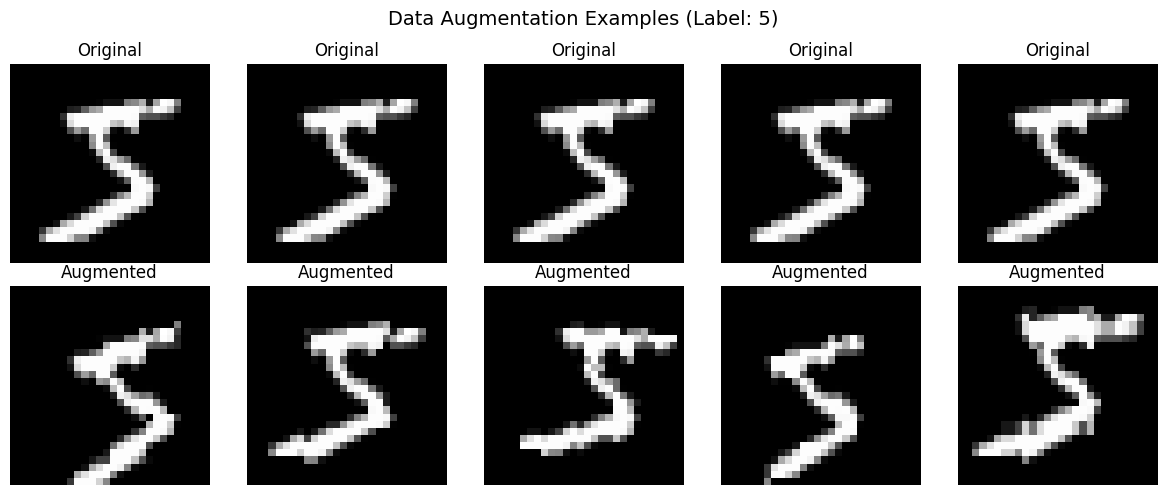

In [86]:
# แสดงผล augmentation บนรูปเดียวกัน
fig, axes = plt.subplots(2, 5, figsize=(12, 5))

# แถวบน: รูปต้นฉบับ (ซ้ำกัน)
original_image, label = mnist_train[0]
for ax in axes[0]:
    ax.imshow(original_image.squeeze(), cmap='gray')
    ax.set_title('Original')
    ax.axis('off')

# แถวล่าง: รูปที่ augment แล้ว (ทุกครั้งจะได้รูปต่างกันเพราะ random)
for ax in axes[1]:
    aug_image, _ = mnist_augmented[0]
    ax.imshow(aug_image.squeeze(), cmap='gray')
    ax.set_title('Augmented')
    ax.axis('off')

plt.suptitle(f'Data Augmentation Examples (Label: {label})', fontsize=14)
plt.tight_layout()

plt.show()

## 3.4 Transforms สำหรับ CIFAR-10 (Color Images)

**สำหรับรูปสี (RGB) ต้องระวัง:**
- mean/std ต้องมี 3 ค่า (แยกแต่ละ channel)
- สามารถใช้ ColorJitter ปรับสี/ความสว่างได้

In [87]:
# Transform สำหรับ training (มี augmentation)
cifar_train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # พลิก 50% ของเวลา
    transforms.RandomCrop(32, padding=4),     # crop แบบสุ่ม (เพิ่มขอบ 4 pixel ก่อน)
    transforms.ColorJitter(
        brightness=0.2,   # ความสว่าง ±20%
        contrast=0.2,     # contrast ±20%
        saturation=0.2    # ความอิ่มตัว ±20%
    ),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],  # CIFAR-10 RGB mean
        std=[0.2470, 0.2435, 0.2616]    # CIFAR-10 RGB std
    )
])

# Transform สำหรับ test (ไม่มี augmentation - ต้องการผลที่คงที่)
cifar_test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2470, 0.2435, 0.2616]
    )
])

print("CIFAR-10 transforms ready!")

CIFAR-10 transforms ready!


In [88]:
# โหลด CIFAR-10
cifar_train = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=cifar_train_transform
)

cifar_test = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=cifar_test_transform
)

# Class names
cifar_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                 'dog', 'frog', 'horse', 'ship', 'truck']

print(f"CIFAR-10 Training: {len(cifar_train)} images")
print(f"CIFAR-10 Test: {len(cifar_test)} images")
print(f"Classes: {cifar_classes}")

CIFAR-10 Training: 50000 images
CIFAR-10 Test: 10000 images
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


## 3.5 แสดง CIFAR-10 Samples

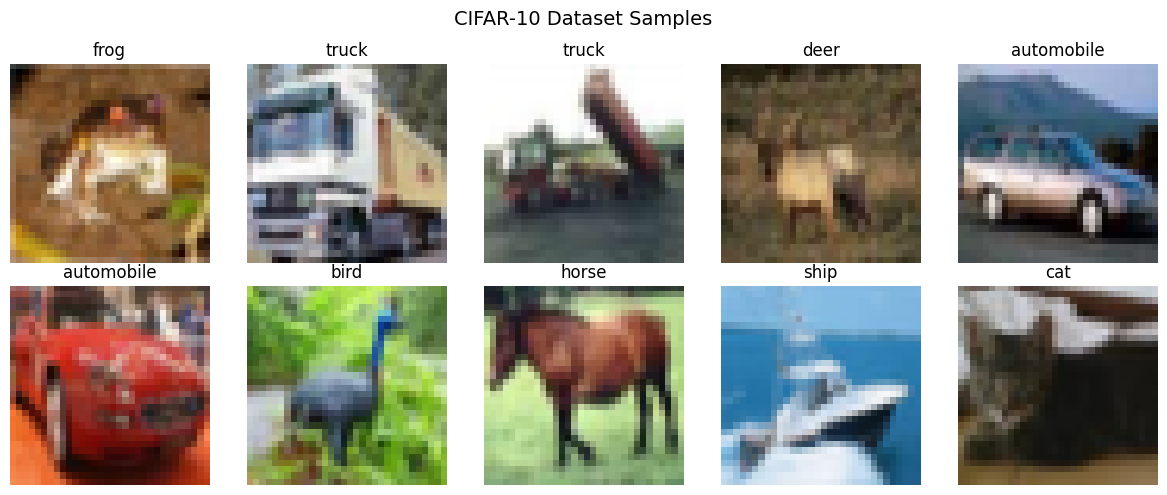

In [89]:
# แสดงตัวอย่าง CIFAR-10 (ไม่ใช้ augmentation เพื่อให้เห็นรูปชัด)
cifar_raw = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True,
    transform=transforms.ToTensor()
)

fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    image, label = cifar_raw[i]
    # Transpose จาก (C, H, W) เป็น (H, W, C) สำหรับ matplotlib
    ax.imshow(image.permute(1, 2, 0))
    ax.set_title(cifar_classes[label])
    ax.axis('off')
plt.suptitle('CIFAR-10 Dataset Samples', fontsize=14)
plt.tight_layout()

plt.show()

---
# 🖼️ Module 4: Convolutional Neural Networks (CNNs)
---

## CNN คืออะไร?

**ปัญหาของ Fully Connected Network กับรูปภาพ:**
- รูป 28×28 = 784 pixels → 784 inputs
- รูป 224×224×3 (RGB) = 150,528 inputs → parameters เยอะมาก!
- ไม่สนใจ spatial structure (pixel ข้างๆ กันมีความสัมพันธ์)

**CNN แก้ปัญหานี้ด้วย:**
1. **Convolutional Layer** → ใช้ filter เล็กๆ (3×3) เลื่อนไปทั่วรูป
2. **Pooling Layer** → ลดขนาด, ทำให้ทนต่อการเลื่อนเล็กน้อย
3. **Fully Connected** → classification ขั้นสุดท้าย

**เปรียบเทียบ:** เหมือนการอ่านหนังสือ
- FC Network = ดูทุกตัวอักษรพร้อมกัน (งง!)
- CNN = อ่านทีละคำ, ทีละประโยค (เข้าใจ!)

## 4.1 Convolutional Layer

**หลักการ:**
- ใช้ filter/kernel ขนาดเล็ก (เช่น 3×3) เลื่อนไปทั่วรูป
- แต่ละ filter เรียนรู้ pattern เฉพาะ (เช่น ขอบแนวตั้ง, แนวนอน, มุม)

**Parameters สำคัญ:**
- `in_channels` → จำนวน channels ของ input (RGB=3, grayscale=1)
- `out_channels` → จำนวน filters = จำนวน feature maps ที่ได้
- `kernel_size` → ขนาดของ filter (เช่น 3 = 3×3)
- `stride` → เลื่อน filter ทีละกี่ pixel (ปกติ=1)
- `padding` → เพิ่มขอบกี่ pixel (เพื่อรักษาขนาด)

In [90]:
# ตัวอย่าง Conv2d
conv_layer = nn.Conv2d(
    in_channels=3,      # RGB input
    out_channels=16,    # สร้าง 16 feature maps
    kernel_size=3,      # filter 3x3
    stride=1,           # เลื่อนทีละ 1 pixel
    padding=1           # เพิ่มขอบ 1 pixel (รักษาขนาด)
)

# ทดสอบ
x = torch.randn(1, 3, 32, 32)  # 1 รูป, RGB, 32x32
y = conv_layer(x)

print(f"Input shape: {x.shape}")   # (1, 3, 32, 32)
print(f"Output shape: {y.shape}")  # (1, 16, 32, 32)

Input shape: torch.Size([1, 3, 32, 32])
Output shape: torch.Size([1, 16, 32, 32])


## 4.2 คำนวณ Output Size ของ Convolution

**สูตร:**
```
output_size = (input_size - kernel_size + 2*padding) / stride + 1
```

**ตัวอย่าง:**
- Input: 32, kernel: 3, padding: 1, stride: 1
- Output: (32 - 3 + 2×1) / 1 + 1 = 32 ✓ (ขนาดเท่าเดิม)

**เคล็ดลับ:** padding = kernel_size // 2 จะรักษาขนาดได้ (เมื่อ stride=1)

In [91]:
def calc_conv_output_size(input_size, kernel_size, padding, stride):
    """คำนวณขนาด output ของ convolution"""
    return (input_size - kernel_size + 2 * padding) // stride + 1

# ทดสอบ
print("Output sizes:")
print(f"  32x32, k=3, p=1, s=1 -> {calc_conv_output_size(32, 3, 1, 1)} (same)")
print(f"  32x32, k=3, p=0, s=1 -> {calc_conv_output_size(32, 3, 0, 1)} (shrink)")
print(f"  32x32, k=3, p=1, s=2 -> {calc_conv_output_size(32, 3, 1, 2)} (halved)")

Output sizes:
  32x32, k=3, p=1, s=1 -> 32 (same)
  32x32, k=3, p=0, s=1 -> 30 (shrink)
  32x32, k=3, p=1, s=2 -> 16 (halved)


## 4.3 Pooling Layers

**หน้าที่ของ Pooling:**
- ลดขนาดของ feature maps (เช่น 32×32 → 16×16)
- ลดจำนวน parameters และการคำนวณ
- เพิ่ม translation invariance (รูปเลื่อนไปนิดหน่อย ผลยังเหมือนเดิม)

**ประเภท:**
- **MaxPool** → เลือกค่าสูงสุดในแต่ละ region (ใช้บ่อยสุด)
- **AvgPool** → เฉลี่ยค่าในแต่ละ region

In [92]:
# MaxPool2d
maxpool = nn.MaxPool2d(kernel_size=2, stride=2)  # ลดขนาดครึ่งหนึ่ง

x = torch.randn(1, 16, 32, 32)
y = maxpool(x)

print(f"Before MaxPool: {x.shape}")  # (1, 16, 32, 32)
print(f"After MaxPool: {y.shape}")   # (1, 16, 16, 16) - ลดครึ่งหนึ่ง!

Before MaxPool: torch.Size([1, 16, 32, 32])
After MaxPool: torch.Size([1, 16, 16, 16])


## 4.4 สร้าง CNN สำหรับ MNIST

**โครงสร้าง CNN ทั่วไป:**
```
Input → [Conv → ReLU → Pool] × N → Flatten → FC → Output
```

**คิดง่ายๆ:**
- Conv blocks = "มองหา patterns"
- Pooling = "ย่อรูปลง"
- FC = "ตัดสินใจ classification"

In [93]:
class MNISTNet(nn.Module):
    """
    CNN สำหรับ MNIST Classification
    
    โครงสร้าง:
    Input (1, 28, 28)
      ↓
    Conv1 (32 filters) → ReLU → MaxPool → (32, 14, 14)
      ↓
    Conv2 (64 filters) → ReLU → MaxPool → (64, 7, 7)
      ↓
    Flatten → FC1 (128) → ReLU → Dropout → FC2 (10) → Output
    """
    
    def __init__(self):
        super().__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)   # 28→28
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # 14→14
        
        # Pooling
        self.pool = nn.MaxPool2d(2, 2)  # ลดขนาดครึ่งหนึ่ง
        
        # Fully connected layers
        # หลัง 2 ครั้ง pool: 28→14→7, channels: 64
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)  # 10 classes (0-9)
        
        # Dropout สำหรับ regularization (ป้องกัน overfitting)
        self.dropout = nn.Dropout(0.25)
    
    def forward(self, x):
        # Conv block 1: 28→14
        x = self.pool(F.relu(self.conv1(x)))
        
        # Conv block 2: 14→7
        x = self.pool(F.relu(self.conv2(x)))
        
        # Flatten: (batch, 64, 7, 7) → (batch, 64*7*7)
        x = x.view(x.size(0), -1)
        
        # FC layers
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)  # ไม่ใส่ activation (CrossEntropyLoss จัดการให้)
        
        return x

# สร้าง model
mnist_cnn = MNISTNet()
print(mnist_cnn)

# นับ parameters
total_params = sum(p.numel() for p in mnist_cnn.parameters())
print(f"\nTotal parameters: {total_params:,}")

MNISTNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

Total parameters: 421,642


## 4.5 ทดสอบ Forward Pass

In [94]:
# ทดสอบ forward pass
x_test = torch.randn(4, 1, 28, 28)  # batch=4, MNIST size
output = mnist_cnn(x_test)

print(f"Input shape: {x_test.shape}")
print(f"Output shape: {output.shape}")  # (4, 10) - 10 classes
print(f"Output (logits):\n{output[0]}")  # ยังไม่ผ่าน softmax

Input shape: torch.Size([4, 1, 28, 28])
Output shape: torch.Size([4, 10])
Output (logits):
tensor([-0.0869, -0.2835, -0.0144,  0.0115, -0.1489, -0.0152,  0.0564, -0.0545,
         0.0746,  0.1226], grad_fn=<SelectBackward0>)


## 4.6 Train CNN บน MNIST

**ขั้นตอนการ train:**
1. เตรียมข้อมูล (Dataset, DataLoader)
2. สร้าง Model, Loss, Optimizer
3. Training loop: Forward → Loss → Backward → Update
4. Validation: ตรวจสอบ overfitting
5. Test: ประเมินผลสุดท้าย

In [95]:
# เตรียมข้อมูล
mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.1307], [0.3081])
])

train_mnist = torchvision.datasets.MNIST(
    './data', train=True, download=True, transform=mnist_transform
)
test_mnist = torchvision.datasets.MNIST(
    './data', train=False, transform=mnist_transform
)

# แบ่ง train/val
train_size = int(0.9 * len(train_mnist))
val_size = len(train_mnist) - train_size
train_data, val_data = random_split(train_mnist, [train_size, val_size])

# DataLoaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_mnist, batch_size=64, shuffle=False)

print(f"Train: {len(train_data)}, Val: {len(val_data)}, Test: {len(test_mnist)}")

Train: 54000, Val: 6000, Test: 10000


## 4.7 Training Function

In [96]:
def train_epoch(model, loader, criterion, optimizer, device):
    """
    Train 1 epoch
    
    Returns:
        average loss, accuracy
    """
    model.train()  # เปิด training mode (Dropout ทำงาน)
    total_loss = 0
    correct = 0
    total = 0
    
    for X_batch, y_batch in loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        
        # Backward pass
        optimizer.zero_grad()  # ล้าง gradients เก่า
        loss.backward()        # คำนวณ gradients
        optimizer.step()       # update weights
        
        # Statistics
        total_loss += loss.item() * X_batch.size(0)
        _, predicted = outputs.max(1)  # argmax
        correct += predicted.eq(y_batch).sum().item()
        total += y_batch.size(0)
    
    return total_loss / total, correct / total

def evaluate(model, loader, criterion, device):
    """
    Evaluate model (ไม่ update weights)
    
    Returns:
        average loss, accuracy
    """
    model.eval()  # ปิด training mode (Dropout ไม่ทำงาน)
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():  # ไม่ต้องเก็บ gradients (ประหยัด memory)
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            
            total_loss += loss.item() * X_batch.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(y_batch).sum().item()
            total += y_batch.size(0)
    
    return total_loss / total, correct / total

## 4.8 Training Loop with Progress

In [97]:
# สร้าง model, criterion, optimizer
model = MNISTNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training
n_epochs = 5
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

print("Starting training...")
print("-" * 60)

for epoch in range(n_epochs):
    start_time = time.time()
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    elapsed = time.time() - start_time
    print(f"Epoch {epoch+1}/{n_epochs} ({elapsed:.1f}s) | "
          f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

print("-" * 60)
print("Training complete!")

# Test
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f"Test Accuracy: {test_acc:.4f}")

Starting training...
------------------------------------------------------------
Epoch 1/5 (4.2s) | Train Loss: 0.1721, Acc: 0.9464 | Val Loss: 0.0602, Acc: 0.9815
Epoch 2/5 (4.1s) | Train Loss: 0.0573, Acc: 0.9829 | Val Loss: 0.0434, Acc: 0.9855
Epoch 3/5 (4.1s) | Train Loss: 0.0422, Acc: 0.9869 | Val Loss: 0.0402, Acc: 0.9882
Epoch 4/5 (4.1s) | Train Loss: 0.0317, Acc: 0.9901 | Val Loss: 0.0327, Acc: 0.9900
Epoch 5/5 (4.2s) | Train Loss: 0.0252, Acc: 0.9917 | Val Loss: 0.0368, Acc: 0.9880
------------------------------------------------------------
Training complete!
Test Accuracy: 0.9895


## 4.9 Visualize Training History

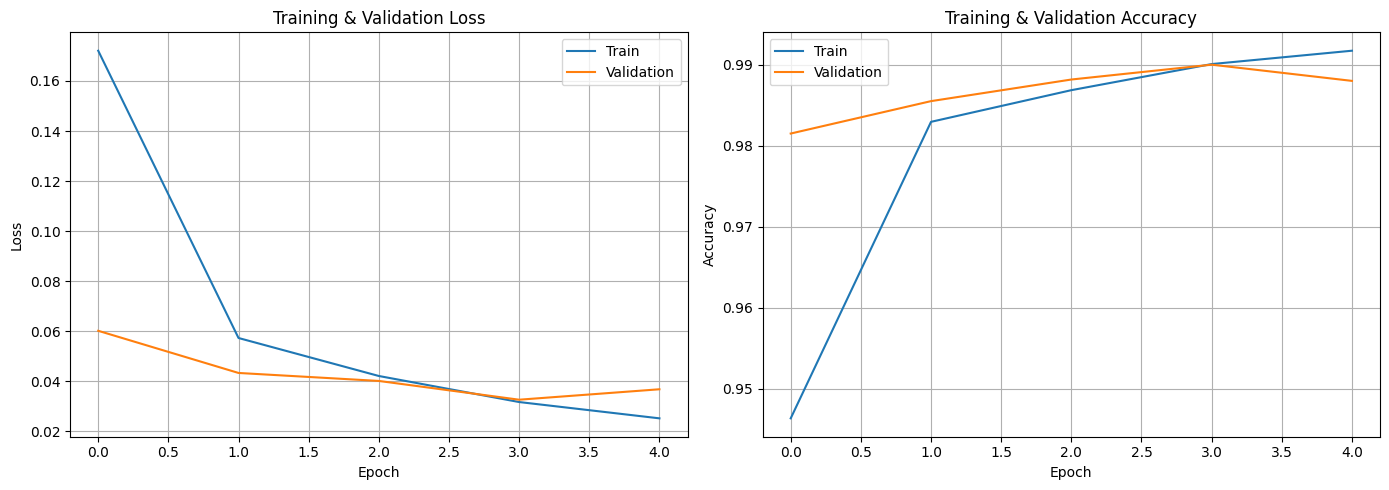

In [98]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss
axes[0].plot(history['train_loss'], label='Train')
axes[0].plot(history['val_loss'], label='Validation')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training & Validation Loss')
axes[0].legend()
axes[0].grid(True)

# Accuracy
axes[1].plot(history['train_acc'], label='Train')
axes[1].plot(history['val_acc'], label='Validation')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training & Validation Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()

plt.show()

## 4.10 CNN สำหรับ CIFAR-10 (ซับซ้อนขึ้น)

**CIFAR-10 ยากกว่า MNIST เพราะ:**
- รูปสี (3 channels) vs grayscale (1 channel)
- Object มีหลายรูปแบบ vs ตัวเลขค่อนข้างมาตรฐาน
- Background ซับซ้อน vs พื้นหลังเรียบ

**ดังนั้นต้อง:**
- ใช้ layers มากขึ้น
- ใช้ Batch Normalization (ช่วยให้ train เสถียร)
- ใช้ Dropout มากขึ้น

In [99]:
class CIFAR10Net(nn.Module):
    """
    CNN สำหรับ CIFAR-10
    
    โครงสร้าง: VGG-style blocks
    Block = [Conv → BN → ReLU → Conv → BN → ReLU → MaxPool → Dropout]
    """
    
    def __init__(self, num_classes=10):
        super().__init__()
        
        # Block 1: 32x32 → 16x16
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)
        )
        
        # Block 2: 16x16 → 8x8
        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)
        )
        
        # Block 3: 8x8 → 4x4
        self.block3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)
        )
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.classifier(x)
        return x

# สร้าง model
cifar_model = CIFAR10Net()
print(cifar_model)

# นับ parameters
total_params = sum(p.numel() for p in cifar_model.parameters())
print(f"\nTotal parameters: {total_params:,}")

CIFAR10Net(
  (block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.25, inplace=False)
  )
  (block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, p

---
# ⚡ Module 6: Training Best Practices
---

**เทคนิคที่ทำให้การ train ดีขึ้น:**
1. Learning Rate Scheduling
2. Early Stopping
3. Gradient Clipping
4. Weight Initialization
5. Batch Normalization

## 6.1 Learning Rate Scheduling

**ปัญหา:** Learning rate คงที่อาจไม่ดีที่สุด
- ตอนแรก: อยากเรียนเร็วๆ → lr สูง
- ตอนท้าย: อยาก fine-tune → lr ต่ำ

**Schedulers ที่ใช้บ่อย:**
- `StepLR` → ลด lr ทุกๆ N epochs (เช่น ทุก 10 epochs ลด 10 เท่า)
- `ReduceLROnPlateau` → ลด lr เมื่อ metric ไม่ดีขึ้น
- `CosineAnnealingLR` → ลดแบบ cosine curve (ค่อยๆ ลด, แล้ว reset)

/home/student/mlops_venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


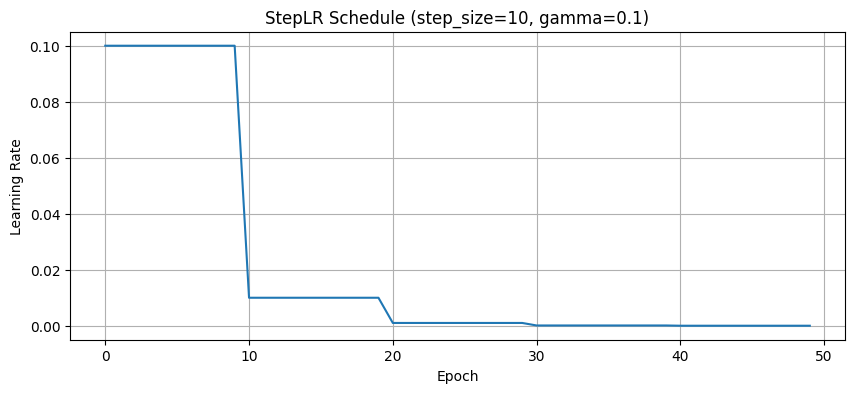

In [100]:
# ตัวอย่าง StepLR
model = nn.Linear(10, 1)
optimizer = optim.Adam(model.parameters(), lr=0.1)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

lrs = []
for epoch in range(50):
    lrs.append(optimizer.param_groups[0]['lr'])
    scheduler.step()

plt.figure(figsize=(10, 4))
plt.plot(lrs)
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('StepLR Schedule (step_size=10, gamma=0.1)')
plt.grid(True)

plt.show()

## 6.2 ReduceLROnPlateau

**หลักการ:** ลด learning rate เมื่อ metric หยุดดีขึ้น
- `mode='min'` → ลดเมื่อ loss ไม่ลดลง
- `patience=5` → รอ 5 epochs ก่อนลด
- `factor=0.5` → ลดลงครึ่งหนึ่ง

**ข้อดี:** ปรับตัวอัตโนมัติตามสถานการณ์

In [101]:
# ตัวอย่าง ReduceLROnPlateau
model = nn.Linear(10, 1)
optimizer = optim.Adam(model.parameters(), lr=0.1)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min',      # ลดเมื่อ loss ไม่ลด
    patience=5,      # รอ 5 epochs
    factor=0.5       # ลดลงครึ่งหนึ่ง
)

# การใช้งาน:
# scheduler.step(val_loss)  # เรียกหลังทุก epoch

print("ReduceLROnPlateau: reduce lr when validation loss doesn't decrease for 5 epochs")

ReduceLROnPlateau: reduce lr when validation loss doesn't decrease for 5 epochs


## 6.3 Early Stopping

**หลักการ:** หยุด train เมื่อ validation loss ไม่ดีขึ้นแล้ว

**ทำไมต้องหยุด?**
- ป้องกัน overfitting
- ประหยัดเวลา
- เก็บ model ที่ดีที่สุดไว้

In [102]:
class EarlyStopping:
    """
    Early Stopping เพื่อป้องกัน overfitting
    
    หยุด train เมื่อ validation loss ไม่ดีขึ้นเป็นเวลา patience epochs
    """
    
    def __init__(self, patience=7, min_delta=0, restore_best_weights=True):
        """
        Args:
            patience: จำนวน epochs ที่รอ
            min_delta: ค่าต่ำสุดที่ถือว่าดีขึ้น
            restore_best_weights: คืน weights ที่ดีที่สุดหรือไม่
        """
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_loss = None
        self.counter = 0
        self.best_weights = None
        self.early_stop = False
    
    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_weights = model.state_dict().copy()
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                if self.restore_best_weights:
                    model.load_state_dict(self.best_weights)
        else:
            self.best_loss = val_loss
            self.best_weights = model.state_dict().copy()
            self.counter = 0
        
        return self.early_stop

# ตัวอย่างการใช้งาน
print("Early Stopping Example:")
print("""
early_stopping = EarlyStopping(patience=7)

for epoch in range(max_epochs):
    train_loss = train_epoch(...)
    val_loss = evaluate(...)
    
    if early_stopping(val_loss, model):
        print(f"Early stopping at epoch {epoch}")
        break
""")

Early Stopping Example:

early_stopping = EarlyStopping(patience=7)

for epoch in range(max_epochs):
    train_loss = train_epoch(...)
    val_loss = evaluate(...)

    if early_stopping(val_loss, model):
        print(f"Early stopping at epoch {epoch}")
        break



## 6.4 Gradient Clipping

**ปัญหา:** Exploding Gradients
- Gradient ใหญ่มากจน weights เปลี่ยนรุนแรง
- พบบ่อยใน RNN

**วิธีแก้:** จำกัดขนาดของ gradient
- ถ้า ||gradient|| > max_norm → scale ลง

In [103]:
# Gradient Clipping
model = nn.Linear(10, 1)
optimizer = optim.SGD(model.parameters(), lr=0.1)

# สร้าง gradient
x = torch.randn(4, 10, requires_grad=True)
y = torch.randn(4, 1)

output = model(x)
loss = ((output - y) ** 2).mean()
loss.backward()

# ก่อน clip
print(f"Gradient norm before clip: {model.weight.grad.norm():.4f}")

# Clip gradient (ทำหลัง backward, ก่อน optimizer.step)
torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

# หลัง clip
print(f"Gradient norm after clip: {model.weight.grad.norm():.4f}")

Gradient norm before clip: 1.4960
Gradient norm after clip: 0.9993


## 6.5 Weight Initialization

**ทำไมสำคัญ:**
- Weights เริ่มต้นที่ดี → train เร็วขึ้น, converge ดีขึ้น
- Weights แย่ → vanishing/exploding gradients

**วิธีที่ใช้บ่อย:**
- **Xavier/Glorot** → สำหรับ tanh, sigmoid
- **Kaiming/He** → สำหรับ ReLU (แนะนำ!)
- **Orthogonal** → สำหรับ RNN

In [104]:
def init_weights(module):
    """
    Initialize weights ตาม best practices
    """
    if isinstance(module, nn.Linear):
        # Kaiming init สำหรับ ReLU
        nn.init.kaiming_normal_(module.weight, nonlinearity='relu')
        if module.bias is not None:
            nn.init.zeros_(module.bias)
    
    elif isinstance(module, nn.Conv2d):
        # Kaiming init สำหรับ Conv
        nn.init.kaiming_normal_(module.weight, nonlinearity='relu')
        if module.bias is not None:
            nn.init.zeros_(module.bias)
    
    elif isinstance(module, nn.LSTM):
        # Orthogonal init สำหรับ RNN
        for name, param in module.named_parameters():
            if 'weight_ih' in name:
                nn.init.xavier_uniform_(param.data)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param.data)
            elif 'bias' in name:
                nn.init.zeros_(param.data)

# ใช้งาน
model = MNISTNet()
model.apply(init_weights)  # apply ไปทุก module
print("Weights initialized!")

Weights initialized!


## 6.6 Batch Normalization

**หลักการ:** Normalize activations ในแต่ละ layer
- ทำให้ mean≈0, std≈1 ในแต่ละ batch

**ประโยชน์:**
- Train เร็วขึ้น (ใช้ lr สูงได้)
- Regularization effect เล็กน้อย
- Gradient flow ดีขึ้น

**ตำแหน่ง:** หลัง Linear/Conv, ก่อน activation

In [105]:
class NetWithBN(nn.Module):
    """Network with Batch Normalization"""
    
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.bn1 = nn.BatchNorm1d(256)  # BN หลัง linear
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 10)
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.bn1(self.fc1(x)))  # Linear → BN → ReLU
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x

model_bn = NetWithBN()
print(model_bn)

NetWithBN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


## 6.7 Complete Training Loop with Best Practices

In [106]:
def train_with_best_practices(model, train_loader, val_loader, 
                               criterion, optimizer, scheduler,
                               n_epochs, device, patience=10):
    """
    Training loop พร้อม best practices ทั้งหมด:
    - Learning rate scheduling
    - Early stopping
    - Gradient clipping
    """
    early_stopping = EarlyStopping(patience=patience)
    history = {'train_loss': [], 'val_loss': [], 'val_acc': [], 'lr': []}
    
    for epoch in range(n_epochs):
        # === Training ===
        model.train()
        train_loss = 0
        
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        
        # === Validation ===
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                output = model(X_batch)
                val_loss += criterion(output, y_batch).item()
                
                _, predicted = output.max(1)
                correct += predicted.eq(y_batch).sum().item()
                total += y_batch.size(0)
        
        val_loss /= len(val_loader)
        val_acc = correct / total
        
        # Learning rate scheduling
        if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(val_loss)
        else:
            scheduler.step()
        
        current_lr = optimizer.param_groups[0]['lr']
        
        # Save history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['lr'].append(current_lr)
        
        print(f"Epoch {epoch+1}/{n_epochs} | "
              f"Train Loss: {train_loss:.4f} | "
              f"Val Loss: {val_loss:.4f} | "
              f"Val Acc: {val_acc:.4f} | "
              f"LR: {current_lr:.6f}")
        
        # Early stopping
        if early_stopping(val_loss, model):
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    return history

print("Training function with best practices ready!")

Training function with best practices ready!


---
# 🚀 Module 7: GPU Optimization
---

**เทคนิคการใช้ GPU อย่างมีประสิทธิภาพ:**
1. Memory Management
2. Mixed Precision Training (FP16)
3. DataLoader Optimization

## 7.1 Memory Management

**GPU memory มีจำกัด ต้องระวัง:**
- ลบ tensor ที่ไม่ใช้
- ใช้ `torch.no_grad()` ตอน inference
- Batch size ใหญ่เกินไป → Out of Memory

In [107]:
if torch.cuda.is_available():
    print("GPU Memory Info:")
    print(f"   Total: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    print(f"   Allocated: {torch.cuda.memory_allocated() / 1e9:.4f} GB")
    print(f"   Cached: {torch.cuda.memory_reserved() / 1e9:.4f} GB")
    
    # ล้าง cache
    torch.cuda.empty_cache()
    print("   Cache cleared!")
else:
    print("GPU not available")

GPU Memory Info:
   Total: 34.19 GB
   Allocated: 0.0181 GB
   Cached: 0.0818 GB
   Cache cleared!


## 7.2 Mixed Precision Training (FP16)

**หลักการ:** ใช้ float16 แทน float32
- ลด memory usage ~50%
- เร็วขึ้น 2-3 เท่า (บน GPU ที่รองรับ)
- ความแม่นยำใกล้เคียง float32

**ใช้ได้กับ:** NVIDIA GPU ที่มี Tensor Cores (RTX, V100, A100)

In [108]:
# Mixed Precision Training with AMP (Automatic Mixed Precision)
from torch.cuda.amp import autocast, GradScaler

def train_with_amp(model, train_loader, criterion, optimizer, device):
    """Training with Automatic Mixed Precision"""
    scaler = GradScaler()  # จัดการ gradient scaling
    model.train()
    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass with autocasting (auto เลือก FP16 ที่เหมาะสม)
        with autocast():
            output = model(X_batch)
            loss = criterion(output, y_batch)
        
        # Backward pass with scaling
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

print("""
Mixed Precision Training Pattern:

scaler = GradScaler()

for X, y in dataloader:
    optimizer.zero_grad()
    
    with autocast():
        output = model(X)
        loss = criterion(output, y)
    
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()
""")


Mixed Precision Training Pattern:

scaler = GradScaler()

for X, y in dataloader:
    optimizer.zero_grad()

    with autocast():
        output = model(X)
        loss = criterion(output, y)

    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()



## 7.3 DataLoader Optimization

**การตั้งค่า DataLoader ที่ดี:**
- `num_workers` → ใช้หลาย CPU cores โหลดข้อมูล (แนะนำ 2-8)
- `pin_memory=True` → เร็วขึ้นสำหรับ GPU transfer
- `persistent_workers=True` → ไม่ต้องสร้าง workers ใหม่ทุก epoch
- `prefetch_factor` → โหลดข้อมูลล่วงหน้า

In [109]:
# Optimized DataLoader
def create_optimized_dataloader(dataset, batch_size, is_train=True):
    """
    สร้าง DataLoader ที่ optimize สำหรับ GPU
    """
    return DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=is_train,
        num_workers=4,          # ใช้ 4 processes
        pin_memory=True,        # เร็วขึ้นสำหรับ GPU
        persistent_workers=True, # ไม่ต้องสร้าง workers ใหม่ทุก epoch
        prefetch_factor=2       # โหลด 2 batches ล่วงหน้า
    )

print("Optimized DataLoader settings:")
print("  - num_workers=4 (parallel data loading)")
print("  - pin_memory=True (faster GPU transfer)")
print("  - persistent_workers=True (reuse workers)")
print("  - prefetch_factor=2 (preload batches)")

Optimized DataLoader settings:
  - num_workers=4 (parallel data loading)
  - pin_memory=True (faster GPU transfer)
  - persistent_workers=True (reuse workers)
  - prefetch_factor=2 (preload batches)


## 7.4 Model Optimization: torch.compile (PyTorch 2.0+)

**หลักการ:** PyTorch 2.0 มี JIT compiler ใหม่
- เร็วขึ้น 20-50% โดยไม่ต้องเปลี่ยนโค้ด
- แค่ wrap model ด้วย `torch.compile()`

In [110]:
# torch.compile (PyTorch 2.0+)
if hasattr(torch, 'compile'):
    print("torch.compile available!")
    print("""
Usage:
    
# Before training
model = MyModel()
model = torch.compile(model)  # Just add this line!

# Then use normally
output = model(x)
    """)
else:
    print("torch.compile not available (need PyTorch 2.0+)")

torch.compile available!

Usage:

# Before training
model = MyModel()
model = torch.compile(model)  # Just add this line!

# Then use normally
output = model(x)
    


## 7.5 Profiling: หาจุดคอขวด

**ใช้ profiler หาว่าส่วนไหนช้า:**
- GPU utilization ต่ำ → DataLoader ช้า
- Memory สูงมาก → Batch size ใหญ่เกินไป

In [111]:
# Simple timing
def benchmark_model(model, input_shape, n_iterations=100, device='cpu'):
    """วัดความเร็วของ model"""
    model = model.to(device)
    model.eval()
    
    x = torch.randn(input_shape).to(device)
    
    # Warm up (ครั้งแรกจะช้า)
    with torch.no_grad():
        for _ in range(10):
            _ = model(x)
    
    # Benchmark
    if device == 'cuda':
        torch.cuda.synchronize()  # รอให้ GPU ทำงานเสร็จ
    
    start = time.time()
    with torch.no_grad():
        for _ in range(n_iterations):
            _ = model(x)
    
    if device == 'cuda':
        torch.cuda.synchronize()
    
    elapsed = time.time() - start
    avg_time = elapsed / n_iterations * 1000  # ms
    
    return avg_time

# ทดสอบ
model = MNISTNet()
cpu_time = benchmark_model(model, (32, 1, 28, 28), device='cpu')
print(f"CPU inference time: {cpu_time:.2f} ms per batch")

if torch.cuda.is_available():
    gpu_time = benchmark_model(model, (32, 1, 28, 28), device='cuda')
    print(f"GPU inference time: {gpu_time:.2f} ms per batch")
    print(f"Speedup: {cpu_time/gpu_time:.1f}x")

CPU inference time: 0.93 ms per batch
GPU inference time: 0.17 ms per batch
Speedup: 5.7x


---
# 🧪 Lab: Complete Training Pipeline
---

**รวมทุกอย่างที่เรียนมา!**

In [112]:
# === Complete Training Pipeline ===

# 1. Data Preparation
print("Preparing data...")
transform_train = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.1307], [0.3081])
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.1307], [0.3081])
])

train_dataset = torchvision.datasets.MNIST('./data', train=True, 
                                            transform=transform_train, download=True)
test_dataset = torchvision.datasets.MNIST('./data', train=False, 
                                           transform=transform_test)

# Split train/val
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_data, val_data = random_split(train_dataset, [train_size, val_size])

# DataLoaders
batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True,
                         num_workers=0, pin_memory=torch.cuda.is_available())
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False,
                        num_workers=0, pin_memory=torch.cuda.is_available())
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                         num_workers=0, pin_memory=torch.cuda.is_available())

print(f"   Train: {len(train_data)}, Val: {len(val_data)}, Test: {len(test_dataset)}")

Preparing data...
   Train: 54000, Val: 6000, Test: 10000


In [113]:
# 2. Model
print("\nCreating model...")
model = MNISTNet().to(device)
model.apply(init_weights)
print(f"   Device: {device}")
print(f"   Parameters: {sum(p.numel() for p in model.parameters()):,}")

# 3. Loss, Optimizer, Scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5)

# 4. Training
print("\nTraining...")
history = train_with_best_practices(
    model, train_loader, val_loader,
    criterion, optimizer, scheduler,
    n_epochs=10, device=device, patience=5
)


Creating model...
   Device: cuda
   Parameters: 421,642

Training...
Epoch 1/10 | Train Loss: 0.2134 | Val Loss: 0.0711 | Val Acc: 0.9752 | LR: 0.001000
Epoch 2/10 | Train Loss: 0.0724 | Val Loss: 0.0446 | Val Acc: 0.9862 | LR: 0.001000
Epoch 3/10 | Train Loss: 0.0558 | Val Loss: 0.0434 | Val Acc: 0.9867 | LR: 0.001000
Epoch 4/10 | Train Loss: 0.0476 | Val Loss: 0.0412 | Val Acc: 0.9888 | LR: 0.001000
Epoch 5/10 | Train Loss: 0.0405 | Val Loss: 0.0371 | Val Acc: 0.9887 | LR: 0.001000
Epoch 6/10 | Train Loss: 0.0368 | Val Loss: 0.0436 | Val Acc: 0.9875 | LR: 0.001000
Epoch 7/10 | Train Loss: 0.0336 | Val Loss: 0.0440 | Val Acc: 0.9885 | LR: 0.001000
Epoch 8/10 | Train Loss: 0.0318 | Val Loss: 0.0378 | Val Acc: 0.9898 | LR: 0.001000
Epoch 9/10 | Train Loss: 0.0273 | Val Loss: 0.0436 | Val Acc: 0.9897 | LR: 0.000500
Epoch 10/10 | Train Loss: 0.0172 | Val Loss: 0.0389 | Val Acc: 0.9900 | LR: 0.000500
Early stopping at epoch 10


In [114]:
# 5. Final Evaluation
print("\nFinal Evaluation...")
model.eval()
test_loss = 0
correct = 0
total = 0

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        output = model(X_batch)
        test_loss += criterion(output, y_batch).item()
        _, predicted = output.max(1)
        correct += predicted.eq(y_batch).sum().item()
        total += y_batch.size(0)

test_loss /= len(test_loader)
test_acc = correct / total
print(f"   Test Loss: {test_loss:.4f}")
print(f"   Test Accuracy: {test_acc:.4f}")


Final Evaluation...
   Test Loss: 0.0273
   Test Accuracy: 0.9925


In [115]:
# 6. Save Model
model_path = './best_model.pt'
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'test_accuracy': test_acc,
    'history': history
}, model_path)
print(f"\nModel saved to {model_path}")


Model saved to ./best_model.pt


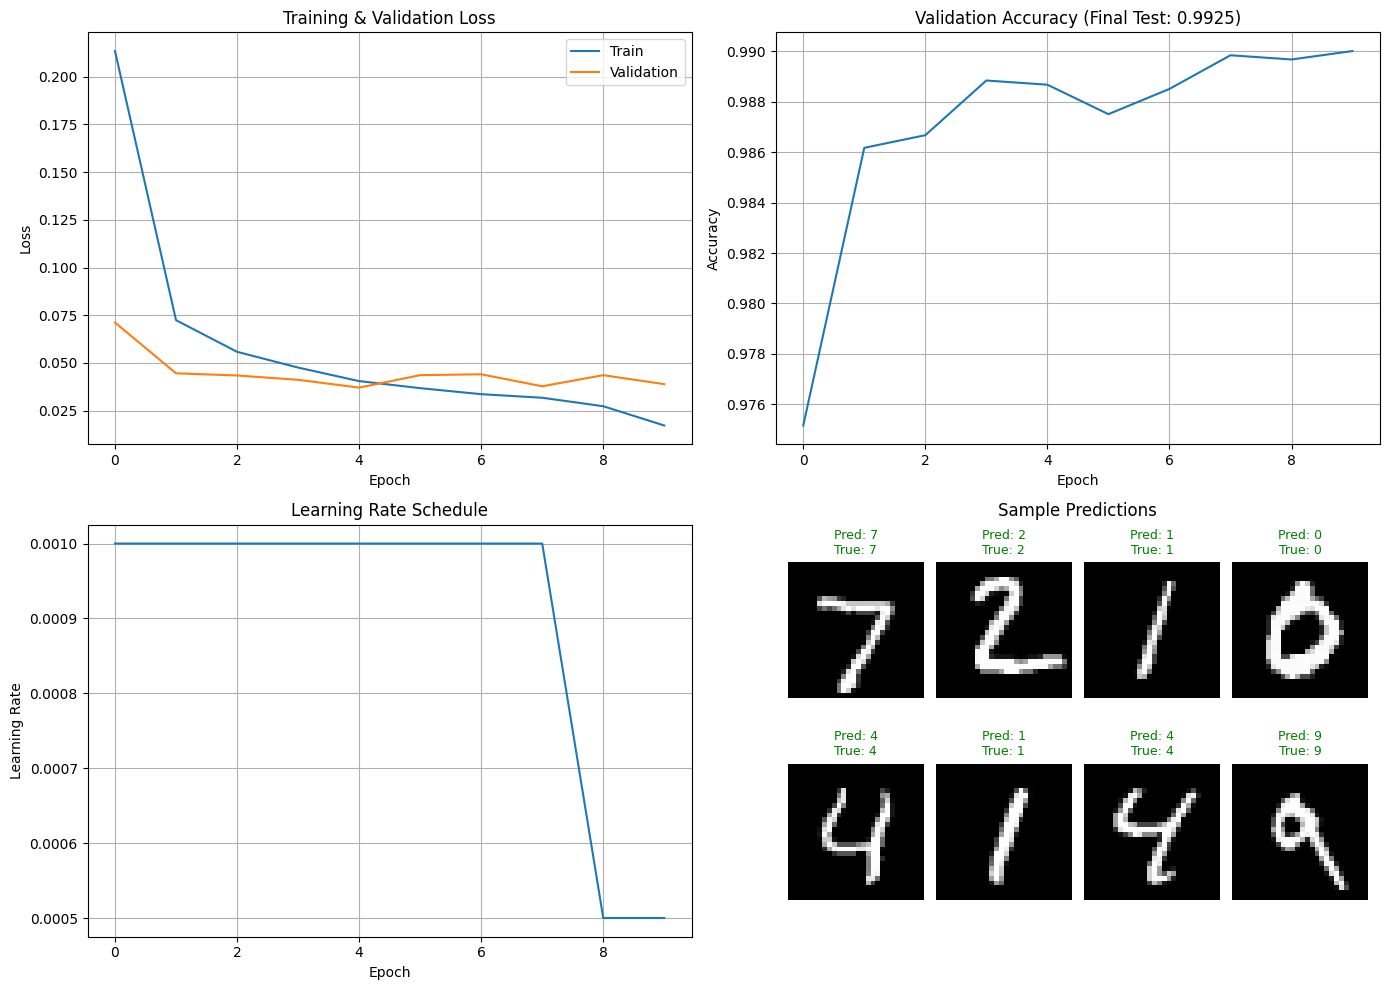

In [116]:
# 7. Visualize Results
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Loss
axes[0, 0].plot(history['train_loss'], label='Train')
axes[0, 0].plot(history['val_loss'], label='Validation')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training & Validation Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Accuracy
axes[0, 1].plot(history['val_acc'])
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].set_title(f'Validation Accuracy (Final Test: {test_acc:.4f})')
axes[0, 1].grid(True)

# Learning Rate
axes[1, 0].plot(history['lr'])
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Learning Rate')
axes[1, 0].set_title('Learning Rate Schedule')
axes[1, 0].grid(True)

# Sample Predictions
model.eval()
images, labels = next(iter(test_loader))
images = images[:8].to(device)
labels = labels[:8].to(device)

with torch.no_grad():
    outputs = model(images)
    preds = outputs.argmax(dim=1)

# Put 8 small plots INSIDE axes[1, 1]
ax_panel = axes[1, 1]
ax_panel.axis('off')
ax_panel.set_title('Sample Predictions')

nrows, ncols = 2, 4
pad = 0.02
cell_w = (1 - pad * (ncols + 1)) / ncols
cell_h = (1 - pad * (nrows + 1)) / nrows

for i in range(8):
    r, c = divmod(i, ncols)
    x0 = pad + c * (cell_w + pad)
    y0 = 1 - pad - (r + 1) * cell_h - r * pad

    ax = ax_panel.inset_axes([x0, y0, cell_w, cell_h])
    img = images[i].detach().cpu()

    if img.ndim == 3 and img.shape[0] == 1:
        ax.imshow(img[0], cmap='gray')
    elif img.ndim == 3 and img.shape[0] == 3:
        ax.imshow(img.permute(1, 2, 0))
    else:
        ax.imshow(img.squeeze(), cmap='gray')

    ok = (preds[i] == labels[i]).item()
    color = 'green' if ok else 'red'
    ax.set_title(f'Pred: {preds[i].item()}\nTrue: {labels[i].item()}',
                 color=color, fontsize=9)
    ax.axis('off')

plt.tight_layout()
plt.show()

---
# 🎉 สรุป Day 2
---

## สิ่งที่เรียนรู้วันนี้:

| Module | หัวข้อ | สิ่งที่ได้เรียน |
|--------|--------|----------------|
| **2** | Datasets & DataLoaders | Custom Dataset, DataLoader, train/val/test split |
| **2.5** | Image Folder DataLoader | ImageFolder, Custom Image Dataset, Weighted Sampling |
| **3** | Transforms | Preprocessing, Data Augmentation |
| **4** | CNN | Conv2d, Pooling, MNIST/CIFAR-10 classification |
| **6** | Best Practices | LR Scheduling, Early Stopping, Weight Init |
| **7** | GPU Optimization | Memory, AMP, DataLoader optimization |

## 🎯 Key Takeaways:

1. **Dataset/DataLoader** แยกกัน: Dataset บอกวิธีเข้าถึง, DataLoader จัดการ batching
2. **ImageFolder** ง่ายที่สุดสำหรับ image classification
3. **Augmentation** ใช้เฉพาะตอน train, ไม่ใช้ตอน val/test
4. **CNN** ดีกว่า FC สำหรับรูปภาพ (parameter น้อยกว่า, เรียนรู้ spatial patterns)
5. **Best Practices** สำคัญ: LR scheduling, early stopping, gradient clipping
6. **GPU Optimization**: pin_memory, num_workers, AMP

## 📚 แหล่งเรียนรู้เพิ่มเติม:
- [PyTorch Tutorials](https://pytorch.org/tutorials/)
- [PyTorch Documentation](https://pytorch.org/docs/)
- [Papers With Code](https://paperswithcode.com/)

In [117]:
print("🎉 Congratulations! You've completed Day 2!")
print("📚 Next: Transfer Learning, Advanced Architectures, Model Deployment")

🎉 Congratulations! You've completed Day 2!
📚 Next: Transfer Learning, Advanced Architectures, Model Deployment
